# Multiclass Support Vector Machine exercise

*Complete y entregue esta hoja de trabajo completa (incluidos sus resultados y cualquier código de apoyo fuera de la hoja de trabajo) con el envío de su tarea.*

En este ejercicio:
    
- implementar una **función de pérdida** completamente vectorizada para el SVM
- implementar la expresión completamente vectorizada para su **gradiente analítico**
- **verifique su implementación** usando gradiente numérico
- use un conjunto de validación para **ajustar la tasa de aprendizaje y la fuerza de regularización**
- **optimizar** la función de pérdida con **SGD**
- **visualizar** los pesos finales aprendidos


In [2]:
# Run some setup code for this notebook.
import random
import numpy as np
from linear_classifiers.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## CIFAR-10 Data Loading and Preprocessing

In [3]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'linear_classifiers/datasets/cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
    del X_train, y_train
    del X_test, y_test
    print('Clear previously loaded data.')
except:
    pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


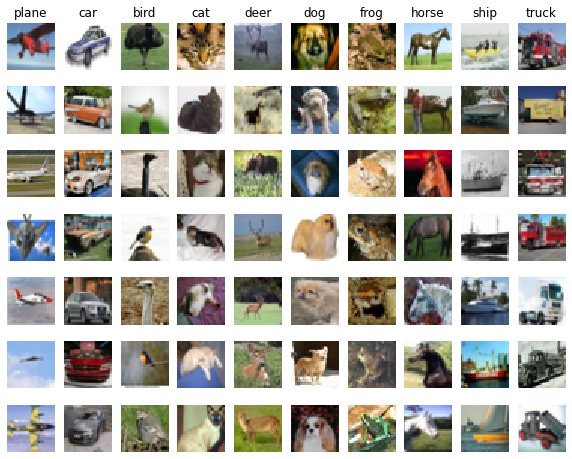

In [6]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
samples_per_class = 7
def visualize_data(dataset, classes, samples_per_class):
    num_classes = len(classes)
    for y, cls in enumerate(classes):
        idxs = np.flatnonzero(y_train == y)
        idxs = np.random.choice(idxs, samples_per_class, replace=False)
        for i, idx in enumerate(idxs):
            plt_idx = i * num_classes + y + 1
            plt.subplot(samples_per_class, num_classes, plt_idx)
            plt.imshow(X_train[idx].reshape((32, 32, 3)).astype('uint8').astype('uint8'))
            plt.axis('off')
            if i == 0:
                plt.title(cls)
    plt.show()
visualize_data(X_train, classes, samples_per_class)

In [7]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 3072)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3072)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [8]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


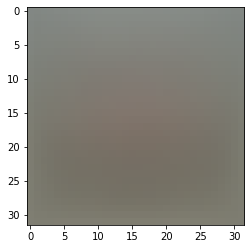

In [9]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

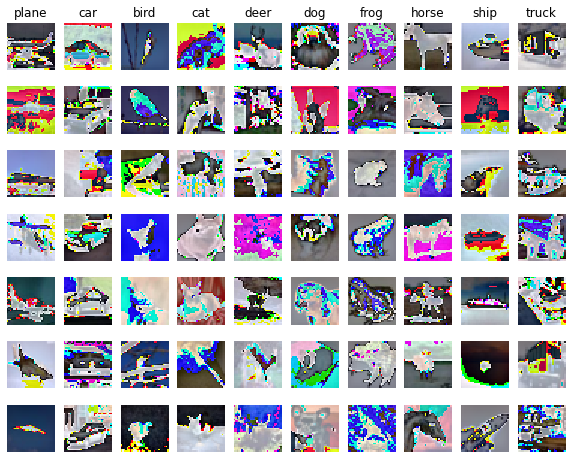

In [10]:
visualize_data(X_train, classes, samples_per_class)

In [11]:
# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


## SVM Classifier

Su código para esta sección se escribirá dentro de `linear_classifiers/classifiers/linear_svm.py`. 

Como puede ver, hemos completado previamente la función `svm_loss_naive` que utiliza bucles for para evaluar la función de pérdida de SVM multiclase.

In [12]:
# Evaluate the naive implementation of the loss we provided for you:
from linear_classifiers.classifiers.linear_svm import svm_loss_naive
import time

# generate a random SVM weight matrix of small numbers
# uncomment the next line to pass the test
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss,))

loss: 9.172089


El `grad` devuelto por la función anterior es ahora todo cero. Derive e implemente la gradiente para la función de costo de SVM e impleméntelo en línea dentro de la función `svm_loss_naive`. Puede resultarte útil calcular `grad` a medida que vas calculando la función de pérdida.

Para comprobar que ha implementado correctamente la gradiente, puede estimar numéricamente la gradiente de la función de pérdida y comparar la estimación numérica con la gradiente que calculó. Hemos proporcionado un código que hace esto por usted:

In [15]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from linear_classifiers.gradient_check import grad_check_sparse

f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: 9.546212 analytic: 0.000000, relative error: 1.000000e+00
numerical: 19.595351 analytic: 0.000000, relative error: 1.000000e+00
numerical: -11.735156 analytic: 0.000000, relative error: 1.000000e+00
numerical: -13.260952 analytic: 0.000000, relative error: 1.000000e+00
numerical: 6.803010 analytic: 0.000000, relative error: 1.000000e+00
numerical: -11.784556 analytic: 0.000000, relative error: 1.000000e+00
numerical: 8.641946 analytic: 0.000000, relative error: 1.000000e+00
numerical: -26.511259 analytic: 0.000000, relative error: 1.000000e+00
numerical: -30.396671 analytic: 0.000000, relative error: 1.000000e+00
numerical: 3.132948 analytic: 0.000000, relative error: 1.000000e+00
numerical: -6.142216 analytic: 0.000000, relative error: 1.000000e+00
numerical: 9.146409 analytic: 0.000000, relative error: 1.000000e+00
numerical: -21.388350 analytic: 0.000000, relative error: 1.000000e+00
numerical: 12.807580 analytic: 0.000000, relative error: 1.000000e+00
numerical: 15.70495

In [16]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.

tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from linear_classifiers.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 9.172089e+00 computed in 0.057864s
Vectorized loss: 0.000000e+00 computed in 0.001000s
difference: 9.172089


In [17]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.067703s
Vectorized loss and gradient: computed in 0.000000s
difference: 0.000000


### Stochastic Gradient Descent

Ahora tenemos expresiones vectorizadas y eficientes para la pérdida, la gradiente y nuestro gradiente coincide con el gradiente numérico. Por lo tanto, estamos listos para hacer SGD para minimizar la pérdida. Su código para esta parte se escribirá dentro de `cs231n/classifiers/linear_classifier.py`.

In [19]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from linear_classifiers.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 0.000000
iteration 100 / 1500: loss 0.000000
iteration 200 / 1500: loss 0.000000
iteration 300 / 1500: loss 0.000000
iteration 400 / 1500: loss 0.000000
iteration 500 / 1500: loss 0.000000
iteration 600 / 1500: loss 0.000000
iteration 700 / 1500: loss 0.000000
iteration 800 / 1500: loss 0.000000
iteration 900 / 1500: loss 0.000000
iteration 1000 / 1500: loss 0.000000
iteration 1100 / 1500: loss 0.000000
iteration 1200 / 1500: loss 0.000000
iteration 1300 / 1500: loss 0.000000
iteration 1400 / 1500: loss 0.000000
That took 0.007984s


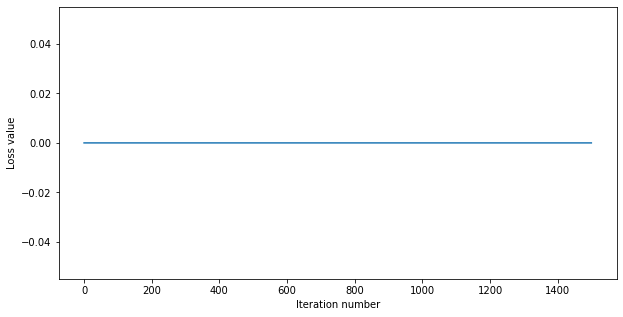

In [20]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.figure(figsize=(10, 5))
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [19]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
# print(y_train_pred.shape)
# print(y_train.shape)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.100265
validation accuracy: 0.087000


In [21]:
# Utilice el conjunto de validación para ajustar los hiperparámetros (valor de regularización y
# learning rate). Deberías experimentar con diferentes rangos para el learning rate y
# los valores de regularización; si tienes cuidado deberías poder
# obtener una precisión de clasificación de aproximadamente 0,39 en el conjunto de validación.

# Nota: es posible que vea advertencias de tiempo de ejecución durante la búsqueda de hiperparámetros.
# Esto puede deberse a valores extremos y no es un error.

# los resultados son tuplas de mapeo de diccionario de la forma
# (learning_rate, regularization_strength) a tuplas del forma
# (training_accuracy, validation_accuracy). La precisión es simplemente la fracción
# de puntos de datos que están clasificados correctamente.
results = {}
best_val = -1   # La mayor precisión de validación que hemos visto hasta ahora.
best_svm = None # El objeto LinearSVM que logró la tasa de validación más alta.

################################################################################
# TODO:                                                                        #
# Escriba código que elija los mejores hiperparámetros ajustándolos al set de validación #
# Para cada combinación de hiperparámetros, entrene un SVM lineal sobre los datos de entrenamiento #
# calcule la precisión o accuracy en los conjuntos de entrenamiento y validación, y #
# almacene estos números en el diccionario de resultados. Además, almacene los mejores #
# valores de accuracy en validación en best_val y el objeto LinearSVM que lo logra #
# en best_svm.                                                    #
#                                                                              #
# Hint: Debe utilizar un valor pequeño para num_iters a medida que desarrolla su #
# código de validación de esa forma SVM no tarda demasiado. Una vez que sepas que funciona tu código de validación #
# entonces si puedes ejecutar con num_iter mas alto #
################################################################################

# Provided as a reference. You may or may not want to change these hyperparameters
learning_rates = [1e-7, 5e-5]
regularization_strengths = [2.5e4, 5e4]

# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
n_iters = 1100
for i in range(len(learning_rates)):
    for j in range(len(regularization_strengths)):
        # instantiate svm object
        svm = LinearSVM()
        # get hyperparams
        lr = learning_rates[i]
        rs = regularization_strengths[j]
        # start training
        svm.train(X_train, y_train, learning_rate=lr, reg=rs,
                      num_iters=n_iters, verbose=True)
        # predictions
        train_acc = np.mean(y_train == svm.predict(X_train))
        val_acc = np.mean(y_val == svm.predict(X_val))
        results[(lr, rs)] = (train_acc, val_acc )
        # compare validations
        if best_val < val_acc:
            best_val = val_acc
            # store svm object
            best_svm = svm

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 1100: loss 0.000000
iteration 100 / 1100: loss 0.000000
iteration 200 / 1100: loss 0.000000
iteration 300 / 1100: loss 0.000000
iteration 400 / 1100: loss 0.000000
iteration 500 / 1100: loss 0.000000
iteration 600 / 1100: loss 0.000000
iteration 700 / 1100: loss 0.000000
iteration 800 / 1100: loss 0.000000
iteration 900 / 1100: loss 0.000000
iteration 1000 / 1100: loss 0.000000
iteration 0 / 1100: loss 0.000000
iteration 100 / 1100: loss 0.000000
iteration 200 / 1100: loss 0.000000
iteration 300 / 1100: loss 0.000000
iteration 400 / 1100: loss 0.000000
iteration 500 / 1100: loss 0.000000
iteration 600 / 1100: loss 0.000000
iteration 700 / 1100: loss 0.000000
iteration 800 / 1100: loss 0.000000
iteration 900 / 1100: loss 0.000000
iteration 1000 / 1100: loss 0.000000
iteration 0 / 1100: loss 0.000000
iteration 100 / 1100: loss 0.000000
iteration 200 / 1100: loss 0.000000
iteration 300 / 1100: loss 0.000000
iteration 400 / 1100: loss 0.000000
iteration 500 / 1100: loss 0.000

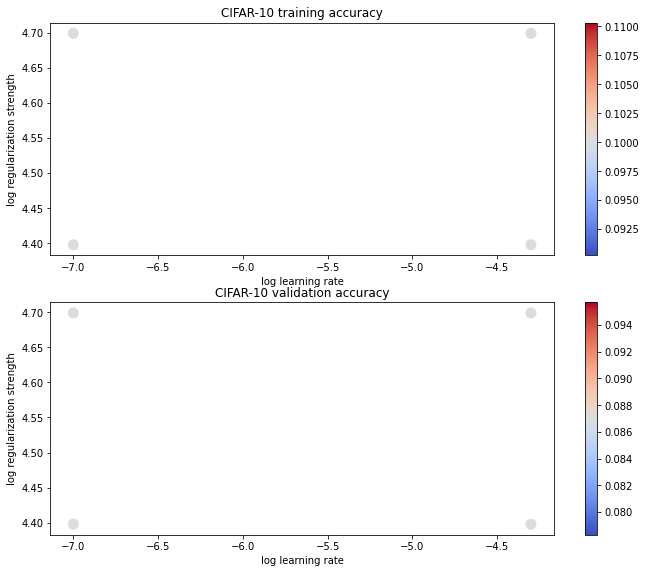

In [21]:
# Visualize the cross-validation results
import math
import pdb

# pdb.set_trace()

x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.tight_layout(pad=3)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [22]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.103000


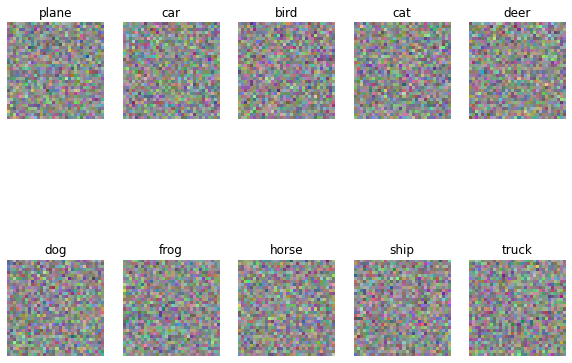

In [23]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

**Inline question 1**

Describa cómo se ven los pesos visualizados de SVM y ofrezca una breve explicación de por qué se ven así.

$\color{blue}{\textit Tu Respuesta:}$ *completa esto*  


Destacan los features mas importantes, obtenidos de los datasets, de cada categoría y tratan de 
mantenerlos o resaltarlos, de forma a generalizar el modelo de la mejor forma posible. 
Ej: bordes, colores